## Data preprocessing

#### Loading G matrix

In [1]:
import rpy2.robjects as robjects
import numpy as np
import pandas as pd
# Load the Rdata file
robjects.r('load("../Geno/GL.RData")')

# Get the list from the Rdata file
G_control = robjects.r('GL$Control')
G_stress = robjects.r('GL$Stress')

# # Convert into numpy array
G_con = pd.DataFrame(np.reshape(G_control, (G_control.nrow, G_control.ncol)), columns = G_control.colnames, index = G_control.rownames)
G_trt = pd.DataFrame(np.reshape(G_stress, (G_stress.nrow, G_stress.ncol)), columns = G_stress.colnames, index = G_stress.rownames)

### Loading Metabolites

In [2]:
import os
metL = []
for i in range(1, 31):
    metL.append(pd.read_csv('../Met/CrossValidation/cv_' + str(i) + '/met_cv_' + str(i) + '.csv'))

In [3]:
def met_read(met_cv1):

    # met_cv1 = pd.read_csv('../Met/CrossValidation/cv_1/met_cv_1.csv')
    met_con_cv1_train = met_cv1.query("Treatment=='Control' and set == 'train'")
    met_con_cv1_test = met_cv1.query("Treatment=='Control' and set == 'test'")
    train_id = np.array(met_con_cv1_train.NSFTV_ID)
    test_id = np.array(met_con_cv1_test.NSFTV_ID)

    G_con_train = G_con.loc[train_id, ] #155*155
    G_con_test = G_con.loc[test_id, ] #38*38
    # Convert pd.dataframe into np.array
    X_train = np.array(G_con_train)
    X_test = np.array(G_con_test)
    Y_train = np.array(met_con_cv1_train.iloc[:,2]) #remove Treatment, set columns 
                                                    #just keep metabolie a1
    Y_test = np.array(met_con_cv1_test.iloc[:,2]) #remove Treatment, set columns 
                                                #just keep metabolie a1
    # print('X_train shape is:', X_train.shape)
    # print('X_test shape is:', X_test.shape)
    # print('Y_train shape is:', Y_train.shape)
    # print('Y_test shape is:', Y_test.shape)

    return X_train, X_test, Y_train, Y_test

## MLP

In [13]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.utils import np_utils
from keras.backend import dropout
from sklearn.metrics import mean_squared_error
from keras.callbacks import EarlyStopping
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [53]:
def MLP(X_train, X_test, Y_train, Y_test):

    seed=42

    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

    model = Sequential(
            [
                Dense(1024, input_shape=(X_train.shape[1],), activation="relu", name = "layer1"),
                Dropout(0.2),
                Dense(512, activation="relu", name = "layer2"),
                Dropout(0.2),
                Dense(512, activation="relu", name = "layer3"),
                Dropout(0.2),
                Dense(1024, activation="relu", name = "layer"),
                Dropout(0.2),
                Dense(1, activation="linear", name = "layer4")
            ]
        )

    # print(model.summary())
    opt = keras.optimizers.legacy.Adam(learning_rate=1e-5)
    model.compile(loss='mse',
                    optimizer=opt,
                    metrics=['mse'])

    nb_epoch = 1000
    batch_size = 50
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=50)

    history = model.fit(X_train, Y_train,
            batch_size=batch_size,
            epochs=nb_epoch,
            verbose=0,
            validation_data=(X_test, Y_test),
            callbacks=[early_stopping])

    Y_pred = model.predict(X_test).reshape(38)

    print("MSE:", mean_squared_error(Y_test, Y_pred))
    print("Corr:", np.corrcoef(Y_test, Y_pred)[0,1])

    print('############################ \n')
    return history

In [54]:
for i in range(0, 11):
    print("NOW is running cv #", i+1)
    X_train, X_test, Y_train, Y_test = met_read(metL[i])
    history = MLP(X_train, X_test, Y_train, Y_test)

2/2 [==============================] - 0s 15ms/step
MSE: 0.002353548718666375
Corr: 0.3223241863235948
############################ 

2/2 [==============================] - 0s 8ms/step
MSE: 0.001211404515492178
Corr: 0.41969345293923616
############################ 

2/2 [==============================] - 0s 5ms/step
MSE: 0.002226829900023756
Corr: 0.1676745456997326
############################ 

2/2 [==============================] - 0s 7ms/step
MSE: 0.0011396455618501403
Corr: 0.2763637920684637
############################ 

2/2 [==============================] - 0s 16ms/step
MSE: 0.0014603648522855041
Corr: 0.1877539374280997
############################ 

2/2 [==============================] - 0s 12ms/step
MSE: 0.001226324633435342
Corr: 0.25710963693617506
############################ 

2/2 [==============================] - 0s 6ms/step
MSE: 0.0009970987288088994
Corr: 0.25270831389689924
############################ 

2/2 [==============================] - 0s 5ms/step
MSE: 0.00

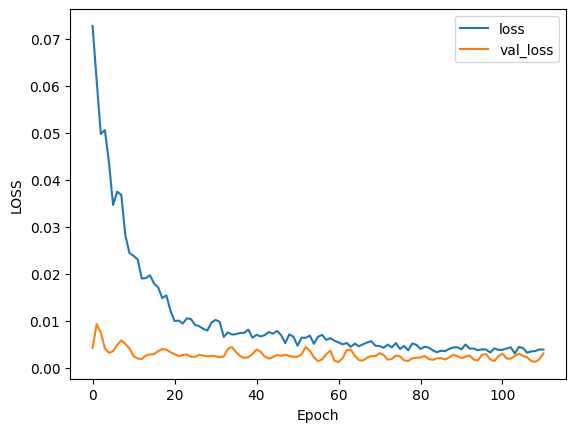

In [56]:

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')

plt.xlabel('Epoch')
plt.ylabel('LOSS')
plt.legend(loc='upper right')



## CNN
https://stackoverflow.com/questions/66220774/difference-between-the-input-shape-for-a-1d-cnn-2d-cnn-and-3d-cnn  
https://www.datatechnotes.com/2019/12/how-to-fit-regression-data-with-cnn.html

In [4]:
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, GlobalAveragePooling1D, GlobalMaxPool1D, MaxPool1D
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
import random
import numpy as np
import tensorflow as tf

In [5]:
def CNN(X_train, X_test, Y_train, Y_test):

    seed=42

    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

    model = Sequential()
    model.add(Conv1D(32, 8, activation="relu", input_shape=(193,1), padding='same'))
    model.add(Conv1D(64, 4, activation="relu", padding='same'))
    # model.add(Conv1D(128, 8, activation="relu"))
    # model.add(Conv1D(512, 8, activation="relu"))
    # model.add(Conv1D(32, 8, activation="relu"))
    # model.add(MaxPool1D())
    model.add(Flatten())
    model.add(Dense(64, activation="relu"))
    model.add(Dense(1))
    opt = keras.optimizers.legacy.Adam(learning_rate=1e-5)
    model.compile(loss="mse", optimizer=opt, metrics=['mse'])
    model.summary()
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)

    history_cnn = model.fit(X_train, Y_train, 
                            batch_size=12,
                            epochs=200, 
                            verbose=0,
                            validation_data=(X_test, Y_test),
                            callbacks=[early_stopping])

    Y_pred = model.predict(X_test).reshape(38)

    print("MSE:", mean_squared_error(Y_test, Y_pred))
    print("Corr:", np.corrcoef(Y_test, Y_pred)[0,1])


    print('############################ \n')
    
    return history_cnn

In [6]:
for i in range(0, 1):
    print("NOW is running cv #", i+1)
    X_train, X_test, Y_train, Y_test = met_read(metL[i])
    history_cnn = CNN(X_train, X_test, Y_train, Y_test)

NOW is running cv # 1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 193, 32)           288       
                                                                 
 conv1d_1 (Conv1D)           (None, 193, 64)           8256      
                                                                 
 flatten (Flatten)           (None, 12352)             0         
                                                                 
 dense (Dense)               (None, 64)                790592    
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 799,201
Trainable params: 799,201
Non-trainable params: 0
_________________________________________________________________


2023-07-27 16:52:27.022113: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


2/2 [==============================] - 0s 22ms/step
MSE: 7.013409348810882e-05
Corr: -0.07116104866413965
############################ 



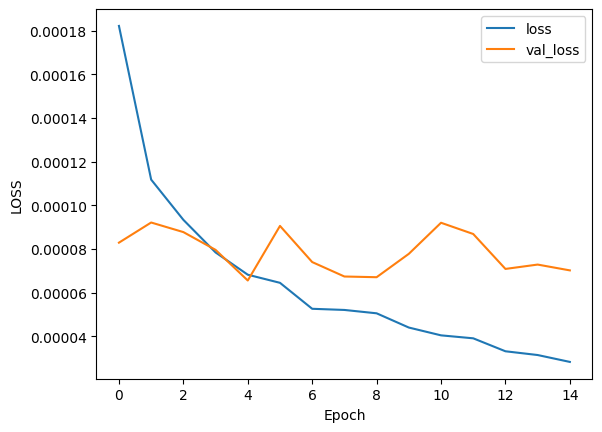

In [7]:
plt.plot(history_cnn.history['loss'], label='loss')
plt.plot(history_cnn.history['val_loss'], label = 'val_loss')

plt.xlabel('Epoch')
plt.ylabel('LOSS')
plt.legend(loc='upper right')


In [8]:
X_train.shape #155*193 

(155, 193)

In [24]:
from sklearn.decomposition import PCA, KernelPCA

In [25]:
fe = KernelPCA(n_components=2,
               kernel = 'rbf', 
               n_jobs=10, 
               random_state=42)

In [38]:
X_train[0, :]

(193,)

In [ ]:
X_new = fe.fit_transform(X_train[0, :].T)

In [33]:
X_new.shape

(193, 2)